In [1]:
!nvidia-smi

Fri Mar 18 17:47:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:1B:00.0 Off |                  N/A |
| 53%   86C    P2   191W / 250W |  10406MiB / 11016MiB |     90%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:1C:00.0 Off |                  N/A |
| 45%   

In [2]:
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.datasets import make_swiss_roll
from nits.model import *

# device = 'cuda:3'
device = 'cpu'

In [3]:
class MLP(nn.Module):
    def __init__(self, arch):
        super(MLP, self).__init__()
        self.layers = self.build_net(arch, name_str='d', linear_final_layer=True)
            
    def build_net(self, arch, name_str='', linear_final_layer=True):
        net = nn.ModuleList()
        for i, (a1, a2) in enumerate(zip(arch[:-1], arch[1:])):
            net.append(nn.Linear(a1, a2))
            
            # add nonlinearities
            if i < len(arch) - 2 or not linear_final_layer:
                net.append(nn.ReLU())
                
        return net

    def forward(self, x):
        y = x
        for l in self.layers:
            y = l(y)
        
        return y
    
class VAEPIN(nn.Module):
    def __init__(self, d, arch=[512, 512], pin_arch=[8, 1], constraint_type='neg_exp',
                 log_var_bias=-5., autoregressive=False, start=-1., end=1.):
        super(VAEPIN, self).__init__()
        self.d = d
        self.arch, self.pin_arch = arch, pin_arch
        self.constraint_type = constraint_type
        self.autoregressive = autoregressive
        
        self.register_buffer('start', torch.tensor([start] * self.d).reshape(1, self.d))
        self.register_buffer('end', torch.tensor([end] * self.d).reshape(1, self.d))
        
        # build PIN models
        
        final_constraint_type = 'softmax'
        if autoregressive:
            self.prior = ConditionalNITS(d=self.d, arch=[d] + pin_arch, start=start, end=end, 
                                        A_constraint=constraint_type, add_residual_connections=True,
                                        final_layer_constraint=final_constraint_type)
            self.posterior = ConditionalNITS(d=self.d, arch=[d] + pin_arch, start=start, end=end, 
                                        A_constraint=constraint_type, add_residual_connections=True,
                                        final_layer_constraint=final_constraint_type)
        else:
            self.prior = NITS(d=self.d, arch=[1] + pin_arch, start=start, end=end, 
                             A_constraint=constraint_type, add_residual_connections=True,
                             final_layer_constraint=final_constraint_type)
            self.posterior = NITS(d=self.d, arch=[1] + pin_arch, start=start, end=end, 
                             A_constraint=constraint_type, add_residual_connections=True,
                             final_layer_constraint=final_constraint_type)  
        
        self.prior_params = torch.nn.Parameter(torch.randn((1, self.prior.tot_params)))
                        
        # build FC layers
        self.pre_encoder = MLP(arch=arch + [self.posterior.tot_params])
        self.decoder = MLP(arch=[d] + arch[::-1])
        
    def parameters(self):
        for param in self.pre_encoder.parameters():
            yield param
            
        for param in self.decoder.parameters():
            yield param
            
        for param in [p for p in self.prior.parameters()]:
            yield param
                                        
    def sample_p_z(self, n):
        z = self.prior.sample(n, self.prior_params)
        
        return z
    
    def sample_p_x(self, n):
        z = self.sample_p_z(n)
        
        x_hat = self.decode(z)
        
        return x_hat
    
    def p_z(self, z):
        p_z = self.prior.pdf(z, self.prior_params)
        p_z = p_z.prod(axis=1, keepdim=True)
            
        return p_z
    
    def p_z_x(self, z, x):
        posterior_params = self.pre_encoder(x).reshape(len(x), self.posterior.tot_params)
        p_z_x = self.posterior.pdf(z, posterior_params)
        p_z_x = p_z_x.prod(axis=1, keepdim=True)
        
        return p_z_x
            
    def encode(self, x):
        posterior_params = self.pre_encoder(x).reshape(len(x), self.posterior.tot_params)
        
        z = self.posterior.sample(1, posterior_params)
        
        return z
        
    def decode(self, z):
        x_hat = self.decoder(z)
        
        return x_hat
    
    def alpha(self, t, scale=1.):
#         t = t * np.pi / 10
#         return torch.sigmoid(1. + torch.sin(t) * scale)
        return torch.sigmoid(torch.tensor(0., device=device))
    
    def train_model(self, x, epochs=100, print_every=20, lr=1e-3, batch_size=128):
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
        t = torch.tensor(0., device=x.device)

        sum_recon_loss = 0.
        sum_kl_loss = 0.

        for e in range(epochs):
            alpha = self.alpha(e)
            for i, x_ in enumerate(create_batcher(x, batch_size=batch_size)):
                x_ = x_.to(device)
                optimizer.zero_grad()

                z = model.encode(x_)
                x_hat = model.decode(z)

                recon_loss = ((x_hat - x_) ** 2).sum()
                kl_loss = (model.p_z_x(z, x_).log() - model.p_z(z).log()).sum()
                loss = alpha * recon_loss + (1 - alpha) * kl_loss
                
                t += 1

                sum_kl_loss += kl_loss.detach().cpu().numpy()
                sum_recon_loss += recon_loss.detach().cpu().numpy()

                loss.backward()

                optimizer.step()

            if e and e % print_every == 0:
                kl_loss = sum_kl_loss / print_every / len(x)
                recon_loss = sum_recon_loss / print_every / len(x)
                print('kl_loss: {:.3f} | recon_loss: {:.3f} | alpha_t {:.3f}'.format(
                    kl_loss, recon_loss, alpha))
                sum_kl_loss, sum_recon_loss = 0., 0.

def create_batcher(x, y=None, batch_size=128):
    idx = 0
    p = torch.randperm(len(x))
    x = x[p]
    
    if y is not None:
        y = y[p]
    
    while idx + batch_size < len(x):
        if y is None:
            yield x[idx:idx+batch_size]
        else:
            yield x[idx:idx+batch_size], y[idx:idx+batch_size]
        idx += batch_size
    else:
        if y is None:
            yield x[idx:]
        else:
            yield x[idx:], y[idx:]
    
def plot_n(X, n):
    _, arr = plt.subplots(n, n)
    arr = arr.reshape(-1)
    X = np.random.permutation(X)
    for i, x in enumerate(X):
        if i == (n * n):
            break
        arr[i].imshow(x.reshape(28, 28), cmap='gray')
        arr[i].axis('off')
        
def random_project(X, dim=2):
    _, d = X.shape
    P = torch.randn((d, 2), device=X.device)
    U, _, _ = torch.linalg.svd(P, full_matrices=False)
    
    return X.mm(U)

def top_components(X, dim=2):
    U, _, _ = torch.linalg.svd(X, full_matrices=False)
    
    return U

def scatter(X, method='', **kwargs):
    if method == 'top_components':
        X = top_components(X)
    elif method == 'random_project':
        X = random_project(X)
       
    plt.figure()
    plt.scatter(X[:,0], X[:,1], **kwargs)

In [4]:
i1, i2 = 0, 1
start, end = -3., 3.

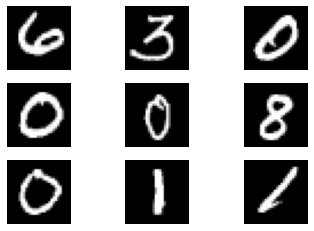

In [5]:
# %matplotlib inline

dataset = 'mnist'

if dataset == 'gaussian':
    n_gaussians = 2
    sig = 0.1
    torch.manual_seed(0)
    n, D, d = 1000, 2, 1#n_gaussians
    
    ns = [int(n / n_gaussians)] * (n_gaussians - 1)
    ns.append(n - np.sum(ns))
    
    mus = torch.randn((n_gaussians, D))
    mus_broadcast = mus.repeat_interleave(torch.tensor(ns), axis=0)
    
    x = torch.randn((n, D)) * sig + mus_broadcast
    
    y = torch.cat([torch.ones(n, 1) * i for i, n in enumerate(ns)], axis=0).to(device)

    # normalize
    x = (x - x.min(axis=0)[0][None,:]) / (x.max(axis=0)[0][None,:] - x.min(axis=0)[0][None,:])
    
    scatter(x.cpu(), c=y.cpu())
    n_classes = n_gaussians
elif dataset == 'mnist':
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = torch.tensor(x_train), torch.tensor(x_test)
    y_train, y_test = torch.tensor(y_train), torch.tensor(y_test)
    x = torch.cat([x_train, x_test], axis=0).reshape(-1, 784).float() / 255.
    y = torch.cat([y_train, y_test], axis=0)
    
    n, D, d = len(x), 784, 10
    
    plot_n(x, n=3)
    
    n_classes = 10
    
x, y = x.to(device), y.to(device)

In [6]:
model = VAEPIN(d=d, arch=[D, 256, 512], 
               pin_arch=[16, 16, 1], 
               constraint_type='neg_exp',
               autoregressive=False, 
               start=start, end=end)

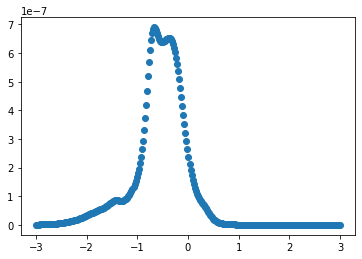

In [7]:
# %matplotlib

x2 = torch.linspace(start, end, 300, device='cpu').reshape(-1, 1).tile((1, d))

y2 = model.p_z(x2)
    
plt.scatter(x2[:,0].detach().cpu(), y2[:,0].detach().cpu())

In [8]:
model = model.to(device)
model.train_model(x, epochs=10000, print_every=10, lr=1e-3)

kl_loss: 6.190 | recon_loss: 35.311 | alpha_t 0.500
kl_loss: 6.713 | recon_loss: 27.678 | alpha_t 0.500
kl_loss: 6.920 | recon_loss: 26.874 | alpha_t 0.500
kl_loss: 7.047 | recon_loss: 26.484 | alpha_t 0.500
kl_loss: 7.117 | recon_loss: 26.248 | alpha_t 0.500
kl_loss: 7.160 | recon_loss: 26.135 | alpha_t 0.500
kl_loss: 7.200 | recon_loss: 25.950 | alpha_t 0.500
kl_loss: 7.246 | recon_loss: 25.796 | alpha_t 0.500
kl_loss: 7.285 | recon_loss: 25.648 | alpha_t 0.500
kl_loss: 7.301 | recon_loss: 25.626 | alpha_t 0.500
kl_loss: 7.319 | recon_loss: 25.591 | alpha_t 0.500
kl_loss: 7.349 | recon_loss: 25.480 | alpha_t 0.500
kl_loss: 7.363 | recon_loss: 25.465 | alpha_t 0.500
kl_loss: 7.390 | recon_loss: 25.331 | alpha_t 0.500
kl_loss: 7.375 | recon_loss: 25.531 | alpha_t 0.500
kl_loss: 7.375 | recon_loss: 25.488 | alpha_t 0.500
kl_loss: 7.417 | recon_loss: 25.277 | alpha_t 0.500
kl_loss: 7.435 | recon_loss: 25.230 | alpha_t 0.500
kl_loss: 7.427 | recon_loss: 25.256 | alpha_t 0.500
kl_loss: 7.4

KeyboardInterrupt: 

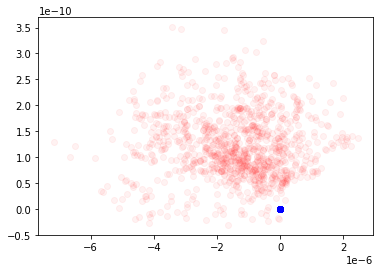

<Figure size 432x288 with 0 Axes>

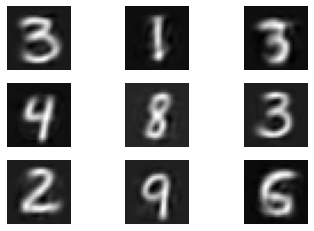

In [9]:
# %matplotlib
model = model.to('cpu')
# model = model.to(device)
# RECONSTRUCTED DATA
x_hat = []

with torch.no_grad():
    for x_ in create_batcher(x.cpu(), batch_size=1024):
        z = model.encode(x_)
        x_hat.append(model.decode(z).cpu().detach())
        break
    
x_hat = torch.cat(x_hat, axis=0)

plt.scatter(x[:,i1].cpu(), x[:,i2].cpu(), c='blue', alpha=0.05)
plt.scatter(x_hat[:,i1], x_hat[:,i2], c='red', alpha=0.05)

plt.figure()

if dataset == 'mnist':
    plot_n(x_hat, n=3)

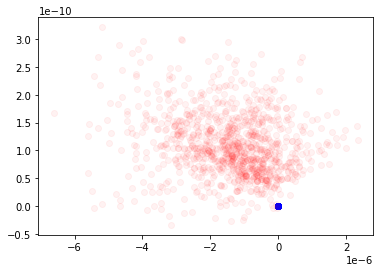

<Figure size 432x288 with 0 Axes>

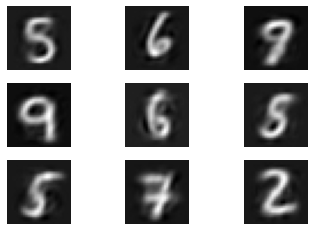

In [10]:
# %matplotlib inline
# GENERATED DATA
with torch.no_grad():
    x_sampled = model.sample_p_x(1000).detach().cpu().numpy()

plt.scatter(x[:,i1].cpu(), x[:,i2].cpu(), c='blue', alpha=0.05)
plt.scatter(x_sampled[:,i1], x_sampled[:,i2], c='red', alpha=0.05)

plt.figure()

if dataset == 'mnist':
    plot_n(x_sampled, n=3)

In [ ]:
# %matplotlib inline

model = model.to('cpu')

n_steps = 300

idx = 0

unif_1d_x = torch.linspace(start, end, n_steps, device='cpu').reshape(-1, 1)
zeros = torch.zeros_like(unif_1d_x) + 0.0

unif_x = [zeros] * d
unif_x[idx] = unif_1d_x

unif_x = torch.cat(unif_x, axis=1)

y_prior = []
y_posteriors = [[] for n_ in range(n_classes)]

with torch.no_grad():
    for x_ in unif_x:
        y_prior.append(model.p_z(x_.reshape(1, d)))
        for n_ in range(n_classes):
            idx_ = n_ * int(n / n_classes)
            y_posteriors[n_].append(model.p_z_x(x_.reshape(1, d), x[idx_][None,:].cpu()))

    y_prior = torch.cat(y_prior, axis=0)
    y_posteriors = [torch.cat(y_posterior, axis=0) for y_posterior in y_posteriors]
    
plt.scatter(unif_x[:,idx].detach().cpu(), y_prior[:,0].detach().cpu(), c='red', alpha=0.1)
for y_posterior in y_posteriors:
    plt.scatter(unif_x[:,idx].detach().cpu(), y_posterior[:,0].detach().cpu(), c='blue', alpha=0.1)
    
plt.ylim(0, 5)

In [ ]:
from matplotlib import cm
%matplotlib inline

# plot prior surface
xs = torch.linspace(start, end, steps=100, device='cpu')
ys = torch.linspace(start, end, steps=100, device='cpu')

unif_x, unif_y = torch.meshgrid(xs, ys, indexing='xy')

unif_xy = torch.cat([unif_x.unsqueeze(-1), unif_y.unsqueeze(-1)], axis=2).reshape(-1, 2)

z = []

with torch.no_grad():
    z = model.p_z(unif_xy)
    
z = z.reshape(unif_x.shape)
    
ax = plt.axes(projection='3d')
ax.plot_surface(unif_x.cpu().numpy(), unif_y.cpu().numpy(), z.cpu().numpy(), cmap=cm.coolwarm);

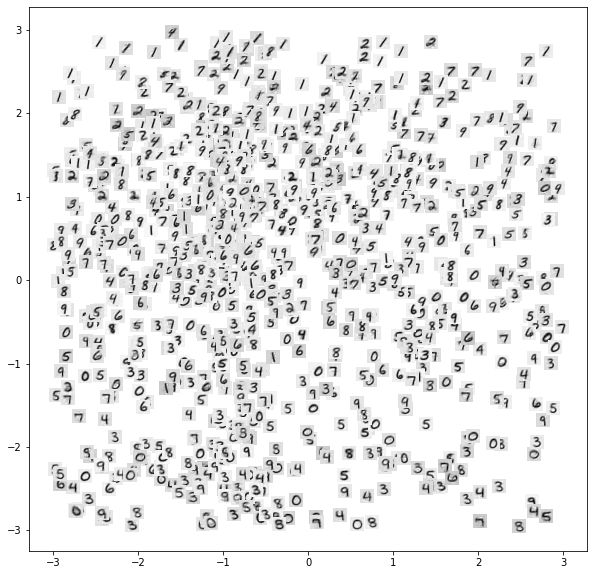

In [11]:
model = model.to('cpu')

%matplotlib inline
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib import cm, colors, colorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable

def imscatter(x, y, images, ax=None, zoom=1, colorby=None, color_mix=0.3, invert_images=False):
    if ax is None:
        ax = plt.gca()
        
    if invert_images:
        images = -images
        
    images = (images - images.min()) / (images.max() - images.min())
        
    if colorby is not None:
        assert len(colorby) == len(images)
        colorby = (colorby - colorby.min()) / (colorby.max() - colorby.min())
        if len(images.shape) == 3:
            images = images.reshape(-1, images.shape[1], images.shape[2], 1).tile((1, 1, 1, 4))
            images[:,:,:,3] = 1.
        norm = colors.Normalize(vmin=colorby.min(), vmax=colorby.max(), clip=True)
        mapper = cm.ScalarMappable(norm=norm, cmap='spring')
        a = color_mix
        
        images = images * (1 - a) + torch.tensor(mapper.to_rgba(colorby)).reshape(-1, 1, 1, 4) * a
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        colorbar.ColorbarBase(ax=cax, cmap=cm.get_cmap('spring'), values=sorted(colorby),
                                 orientation="vertical")

    artists = []
    for x0, y0, im0 in zip(x, y, images):
        im0 = OffsetImage(im0, zoom=zoom, cmap=plt.cm.gray_r)
        ab = AnnotationBbox(im0, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    
    return artists

p = torch.randperm(len(x))
x_subset = x[p][:1000].to('cpu')
with torch.no_grad():
    z = model.encode(x_subset.reshape(-1, 784))
    x_hat = model.decode(z).reshape(-1, 28, 28)

fig, ax = plt.subplots(figsize=(10, 10))
imscatter(z[:,0], z[:,1], x_hat.numpy(), ax=ax, zoom=0.5);

In [12]:
# plot prior surface
xs = torch.linspace(start, end, steps=40, device='cpu')
ys = torch.linspace(start, end, steps=40, device='cpu')

unif_x, unif_y = torch.meshgrid(xs, ys, indexing='xy')

unif_xy = torch.cat([unif_x.unsqueeze(-1), unif_y.unsqueeze(-1)], axis=2).reshape(-1, 2)

with torch.no_grad():
    x_hat = model.decode(unif_xy).cpu().reshape(-1, 28, 28)
    z = model.p_z(unif_xy).log().cpu()
    
z = z.reshape(unif_x.shape)
    
fig, ax = plt.subplots(figsize=(10, 10))
imscatter(unif_x.reshape(-1).numpy(), unif_y.reshape(-1).numpy(), x_hat, ax=ax, zoom=0.5, 
          colorby=z.reshape(-1), invert_images=True);

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1600x2 and 10x512)